In [1]:
# dog_cat_cnn.py
"""
Dog vs Cat classifier (PetImages dataset) using TensorFlow/Keras.

Dataset structure:
    PetImages/
        Dog/
        Cat/

The script automatically splits into train (80%) and val (20%).
"""

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import datetime

# ----------------------------
# Settings
# ----------------------------
DATA_DIR = "PetImages"         # folder containing Dog/ and Cat/
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 15
LEARNING_RATE = 1e-4
USE_TRANSFER_LEARNING = False   # set True to use MobileNetV2

# ----------------------------
# Dataset loader
# ----------------------------
def make_datasets(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    train_ds = keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,      # 80% train, 20% validation
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary"
    )

    val_ds = keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary"
    )

    # Optimize input pipeline
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

# ----------------------------
# Data augmentation
# ----------------------------
def get_augmentation():
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")

# ----------------------------
# Custom CNN
# ----------------------------
def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = get_augmentation()(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="custom_cnn")

# ----------------------------
# Transfer learning (MobileNetV2)
# ----------------------------
def build_transfer_model(input_shape=IMG_SIZE + (3,), base_trainable=False):
    inputs = keras.Input(shape=input_shape)
    x = get_augmentation()(inputs)
    x = layers.Rescaling(1./255)(x)

    base = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base.trainable = base_trainable
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="mobilenetv2")

# ----------------------------
# Plot training curves
# ----------------------------
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo-", label="Training acc")
    plt.plot(epochs, val_acc, "ro-", label="Validation acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo-", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

# ----------------------------
# Main
# ----------------------------
def main():
    print("Loading dataset...")
    train_ds, val_ds = make_datasets(DATA_DIR)

    # Model
    if USE_TRANSFER_LEARNING:
        model = build_transfer_model()
    else:
        model = build_custom_cnn()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    # Callbacks
    checkpoint = keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
    earlystop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystop]
    )

    # Plot curves
    plot_history(history)

    # Save final model
    model.save("dog_cat_final.h5")
    print("Model saved as dog_cat_final.h5")

if __name__ == "__main__":
    main()


Loading dataset...
Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_2897]

In [2]:
# dog_cat_full.py
"""
Dog vs Cat classifier (PetImages dataset) using TensorFlow/Keras.

Steps:
1. Clean dataset (remove broken images).
2. Auto split into train (80%) / val (20%).
3. Train a CNN or MobileNetV2 (transfer learning).
"""

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# Settings
# ----------------------------
DATA_DIR = "PetImages"         # Folder with Dog/ and Cat/
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10
LEARNING_RATE = 1e-4
USE_TRANSFER_LEARNING = False   # set True for MobileNetV2

# ----------------------------
# Step 1: Clean dataset
# ----------------------------
def clean_dataset(folder="PetImages"):
    for category in ["Dog", "Cat"]:
        path = os.path.join(folder, category)
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            try:
                img = Image.open(file_path)
                img.verify()  # check corruption
            except (Exception,):
                print("Removing bad file:", file_path)
                try:
                    os.remove(file_path)
                except:
                    pass

print("Cleaning dataset...")
clean_dataset(DATA_DIR)

# ----------------------------
# Step 2: Load dataset
# ----------------------------
def make_datasets(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    train_ds = keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary",
        color_mode="rgb"   # ensure 3 channels
    )

    val_ds = keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary",
        color_mode="rgb"
    )

    # Optimize input pipeline
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

# ----------------------------
# Step 3: Data augmentation
# ----------------------------
def get_augmentation():
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")

# ----------------------------
# Step 4A: Custom CNN
# ----------------------------
def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = get_augmentation()(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="custom_cnn")

# ----------------------------
# Step 4B: Transfer Learning (MobileNetV2)
# ----------------------------
def build_transfer_model(input_shape=IMG_SIZE + (3,), base_trainable=False):
    inputs = keras.Input(shape=input_shape)
    x = get_augmentation()(inputs)
    x = layers.Rescaling(1./255)(x)

    base = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base.trainable = base_trainable
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="mobilenetv2")

# ----------------------------
# Step 5: Plot curves
# ----------------------------
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo-", label="Training acc")
    plt.plot(epochs, val_acc, "ro-", label="Validation acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo-", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

# ----------------------------
# Main
# ----------------------------
def main():
    print("Loading dataset...")
    train_ds, val_ds = make_datasets(DATA_DIR)

    # Choose model
    if USE_TRANSFER_LEARNING:
        model = build_transfer_model()
    else:
        model = build_custom_cnn()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    # Callbacks
    checkpoint = keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
    earlystop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystop]
    )

    # Plot curves
    plot_history(history)

    # Save final model
    model.save("dog_cat_final.h5")
    print("Model saved as dog_cat_final.h5")

if __name__ == "__main__":
    main()


Cleaning dataset...


c:\Users\lohan\OneDrive\Desktop\all programs\Deep Learning\venv\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Loading dataset...
Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_5794]

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

# -----------------------
# CONFIG
# -----------------------
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "PetImages"  # Folder containing "Dog" and "Cat"

# -----------------------
# CLEAN CORRUPTED IMAGES
# -----------------------
def clean_dataset(data_dir):
    num_deleted = 0
    for category in ["Dog", "Cat"]:
        folder = os.path.join(data_dir, category)
        for file in os.listdir(folder):
            fpath = os.path.join(folder, file)
            try:
                img = Image.open(fpath)
                img.verify()  # Check if corrupted
                img = Image.open(fpath).convert("RGB")  # Ensure RGB
                img.close()
            except Exception:
                os.remove(fpath)
                num_deleted += 1
    print(f"🧹 Cleaned dataset. Deleted {num_deleted} bad images.")

clean_dataset(DATA_DIR)

# -----------------------
# LOAD DATASET
# -----------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -----------------------
# DATA AUGMENTATION
# -----------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------
# CNN MODEL
# -----------------------
def build_model(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="custom_cnn")
    return model

model = build_model()
model.summary()

# -----------------------
# COMPILE MODEL
# -----------------------
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# CALLBACKS
# -----------------------
checkpoint = keras.callbacks.ModelCheckpoint(
    "dog_cat_final.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1
)

# -----------------------
# TRAIN
# -----------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)

# -----------------------
# PLOT TRAINING CURVES
# -----------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


🧹 Cleaned dataset. Deleted 0 bad images.
Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_8683]

🧹 Dataset cleaned. Fixed 0 images, deleted 5 bad files.
Found 24993 files belonging to 2 classes.
Using 19995 files for training.
Found 24993 files belonging to 2 classes.
Using 4998 files for validation.


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5934 - loss: 0.6654

625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 227ms/step - accuracy: 0.6365 - loss: 0.6314 - val_accuracy: 0.7129 - val_loss: 0.5530
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.6975 - loss: 0.5748 - val_accuracy: 0.7107 - val_loss: 0.5586
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7236 - loss: 0.5465

625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 207ms/step - accuracy: 0.7320 - loss: 0.5344 - val_accuracy: 0.7729 - val_loss: 0.4697
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7592 - loss: 0.4975

625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 208ms/step - accuracy: 0.7613 - loss: 0.4957 - val_accuracy: 0.7951 - val_loss: 0.4444
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7809 - loss: 0.4658

625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.7824 - loss: 0.4637 - val_accuracy: 0.8065 - val_loss: 0.4242
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7939 - loss: 0.4432

625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 238ms/step - accuracy: 0.7968 - loss: 0.4402 - val_accuracy: 0.8251 - val_loss: 0.3927
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8099 - loss: 0.4162 - val_accuracy: 0.8201 - val_loss: 0.4003
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8158 - loss: 0.4070

625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 238ms/step - accuracy: 0.8194 - loss: 0.4032 - val_accuracy: 0.8359 - val_loss: 0.3704
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8239 - loss: 0.3884

625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.8241 - loss: 0.3875 - val_accuracy: 0.8529 - val_loss: 0.3398
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.8317 - loss: 0.3778 - val_accuracy: 0.8509 - val_loss: 0.3330
Restoring model weights from the end of the best epoch: 9.


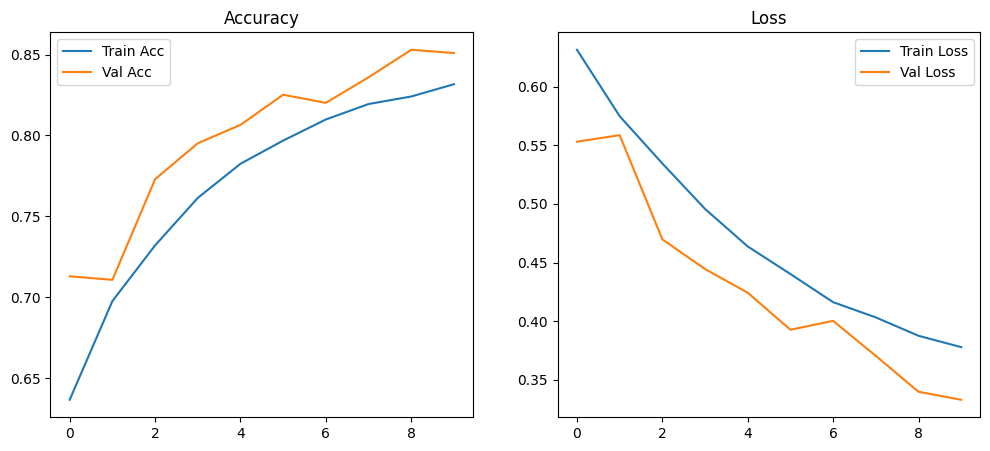

In [4]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image

# -----------------------
# CONFIG
# -----------------------
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "PetImages"  # Folder containing "Dog" and "Cat"

# -----------------------
# CLEAN + FIX DATASET
# -----------------------
def clean_and_fix_dataset(data_dir):
    num_deleted, num_fixed = 0, 0
    for category in ["Dog", "Cat"]:
        folder = os.path.join(data_dir, category)
        for file in os.listdir(folder):
            fpath = os.path.join(folder, file)
            try:
                with Image.open(fpath) as img:
                    img = img.convert("RGB")  # force 3 channels
                    img.save(fpath)  # overwrite fixed version
            except Exception:
                # delete if unreadable
                os.remove(fpath)
                num_deleted += 1
    print(f"🧹 Dataset cleaned. Fixed {num_fixed} images, deleted {num_deleted} bad files.")

clean_and_fix_dataset(DATA_DIR)

# -----------------------
# LOAD DATASET
# -----------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -----------------------
# DATA AUGMENTATION
# -----------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------
# CNN MODEL
# -----------------------
def build_model(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="custom_cnn")

model = build_model()
model.summary()

# -----------------------
# COMPILE
# -----------------------
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# CALLBACKS
# -----------------------
checkpoint = keras.callbacks.ModelCheckpoint(
    "dog_cat_final.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1
)

# -----------------------
# TRAIN
# -----------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)

# -----------------------
# PLOT TRAINING CURVES
# -----------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [9]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


TensorFlow: 2.20.0
GPUs: []



Confusion Matrix:
 [[1953  507]
 [ 228 2310]]

Classification Report:
               precision    recall  f1-score   support

         Cat       0.90      0.79      0.84      2460
         Dog       0.82      0.91      0.86      2538

    accuracy                           0.85      4998
   macro avg       0.86      0.85      0.85      4998
weighted avg       0.86      0.85      0.85      4998



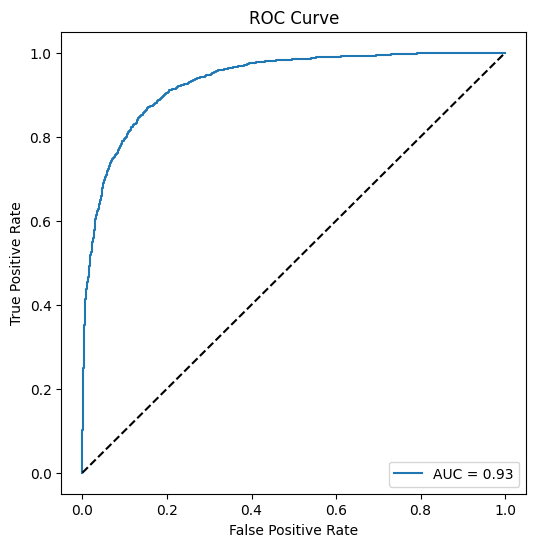

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [12]:
import numpy as np

# Get true labels and predicted probabilities for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_score = model.predict(val_ds).flatten()
y_pred = (y_score > 0.5).astype(int)

# Now you can run the confusion matrix and classification report code in cell 5

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step


🧹 Dataset cleaned. Deleted 0 bad files.
Found 24993 files belonging to 2 classes.
Using 19995 files for training.
Found 24993 files belonging to 2 classes.
Using 4998 files for validation.


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5887 - loss: 0.6813

625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 214ms/step - accuracy: 0.6312 - loss: 0.6402 - val_accuracy: 0.6865 - val_loss: 0.5949
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6921 - loss: 0.5864

625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 226ms/step - accuracy: 0.7085 - loss: 0.5691 - val_accuracy: 0.7635 - val_loss: 0.4981
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 209ms/step - accuracy: 0.7441 - loss: 0.5199 - val_accuracy: 0.7603 - val_loss: 0.4896
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7619 - loss: 0.4938

625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 221ms/step - accuracy: 0.7638 - loss: 0.4906 - val_accuracy: 0.8047 - val_loss: 0.4371
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7804 - loss: 0.4672

625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 216ms/step - accuracy: 0.7807 - loss: 0.4613 - val_accuracy: 0.8189 - val_loss: 0.4032
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7939 - loss: 0.4460

625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 209ms/step - accuracy: 0.7932 - loss: 0.4433 - val_accuracy: 0.8241 - val_loss: 0.3934
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8127 - loss: 0.4189

625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.8098 - loss: 0.4199 - val_accuracy: 0.8373 - val_loss: 0.3760
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.8160 - loss: 0.4043 - val_accuracy: 0.8337 - val_loss: 0.3820
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8243 - loss: 0.3936

625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8263 - loss: 0.3897 - val_accuracy: 0.8397 - val_loss: 0.3536
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8278 - loss: 0.3815

625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 202ms/step - accuracy: 0.8286 - loss: 0.3818 - val_accuracy: 0.8489 - val_loss: 0.3571
Restoring model weights from the end of the best epoch: 10.


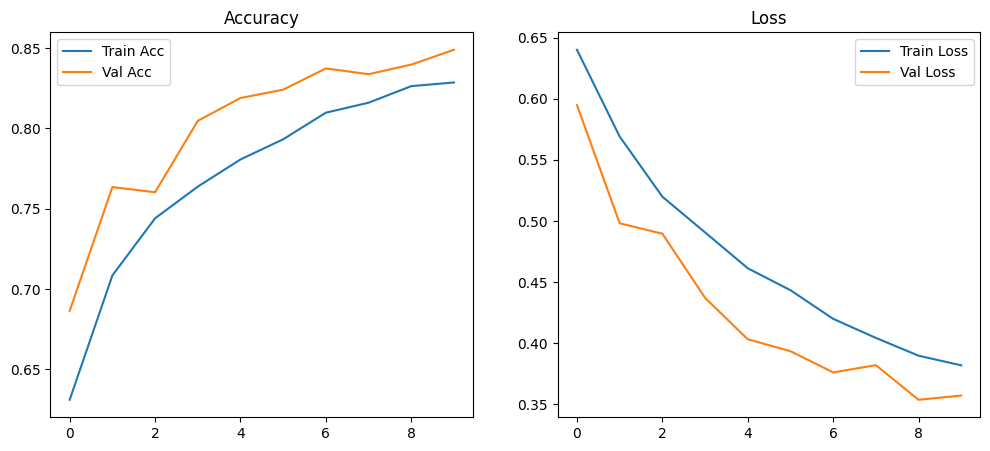

ImportError: cannot import name 'range_op' from 'tensorflow.python.data.ops' (c:\Users\lohan\OneDrive\Desktop\all programs\Deep Learning\venv\Lib\site-packages\tensorflow\python\data\ops\__init__.py)

In [14]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# -----------------------
# CONFIG
# -----------------------
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "PetImages"  # Folder containing "Dog" and "Cat"

# -----------------------
# CLEAN + FIX DATASET
# -----------------------
def clean_and_fix_dataset(data_dir):
    num_deleted, num_fixed = 0, 0
    for category in ["Dog", "Cat"]:
        folder = os.path.join(data_dir, category)
        for file in os.listdir(folder):
            fpath = os.path.join(folder, file)
            try:
                with Image.open(fpath) as img:
                    img = img.convert("RGB")  # force 3 channels
                    img.save(fpath)  # overwrite fixed version
            except Exception:
                os.remove(fpath)
                num_deleted += 1
    print(f"🧹 Dataset cleaned. Deleted {num_deleted} bad files.")

clean_and_fix_dataset(DATA_DIR)

# -----------------------
# LOAD DATASET
# -----------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -----------------------
# DATA AUGMENTATION
# -----------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------
# CNN MODEL
# -----------------------
def build_model(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="custom_cnn")

model = build_model()
model.summary()

# -----------------------
# COMPILE
# -----------------------
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# CALLBACKS
# -----------------------
checkpoint = keras.callbacks.ModelCheckpoint(
    "dog_cat_final.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1
)

# -----------------------
# TRAIN
# -----------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)

# -----------------------
# PLOT TRAINING CURVES
# -----------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

# -----------------------
# EVALUATION METRICS
# -----------------------
y_true = []
y_pred = []
y_score = []

for images, labels in val_ds:
    preds = model.predict(images).ravel()
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32"))
    y_score.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()